In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

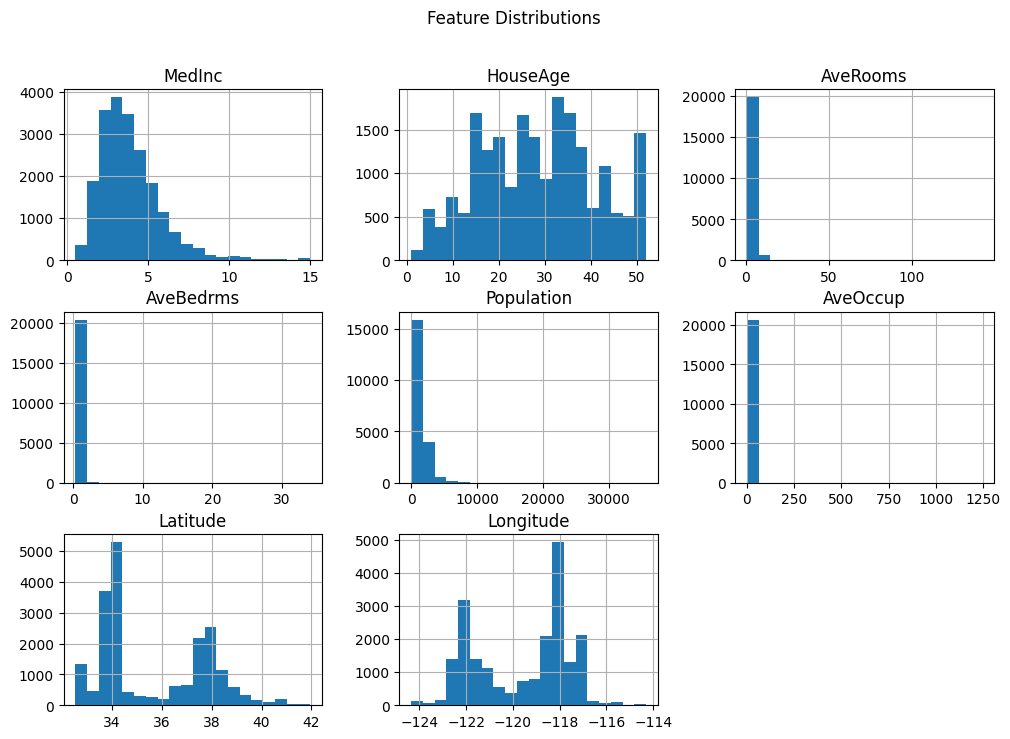

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

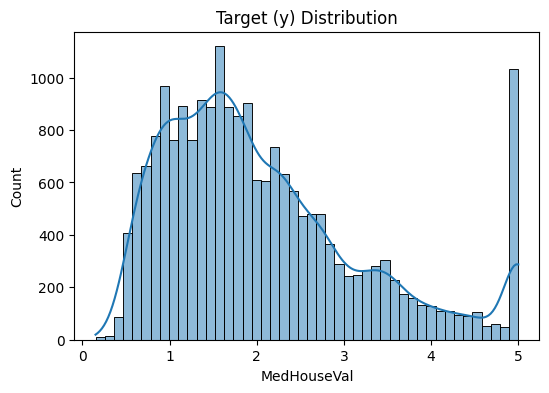

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

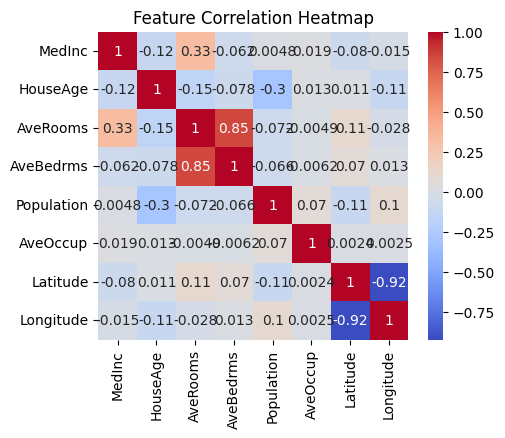

In [7]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [9]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=500, nskip=200, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.890256                 1.856506             1.560116   
1                  1.690201                 1.800829             1.646381   
2                  1.907467                 1.768960             2.033636   
3                  1.714436                 1.940803             2.004641   
4                  1.717793                 1.661470             1.707655   
mean               1.784031                 1.805714             1.790486   
std                0.105541                 0.103694             0.215454   

      DefaultBART_Rhat_RMSE  
0                  1.883677  
1                  1.869486  
2                  1.850063  
3                  2.166397  
4                  1.794166  
mean               1.912758  
std                0.145813  


In [10]:
rhat_df.to_csv("results/real3_CalHousing_rhat.csv", index=False)

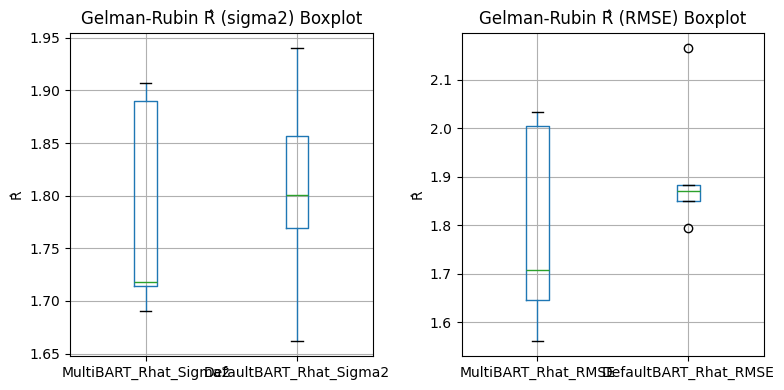

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.215417  0.218779  0.284305  0.272077  0.218599
1      0.215492  0.227126  0.289723  0.261053  0.217833
2      0.221665  0.236712  0.290290  0.262780  0.226877
3      0.206275  0.208025  0.273101  0.244403  0.213037
4      0.218694  0.224251  0.277822  0.265763  0.223567
5      0.215008  0.229798  0.282850  0.256011  0.223564
6      0.225657  0.229749  0.285769  0.266254  0.228732
7      0.227595  0.225837  0.292375  0.272183  0.226946
8      0.223953  0.227095  0.283058  0.258861  0.219225
9      0.212636  0.225024  0.288779  0.250178  0.214931
mean   0.218239  0.225240  0.284807  0.260956  0.221331
std    0.006563  0.007595  0.005974  0.008964  0.005385



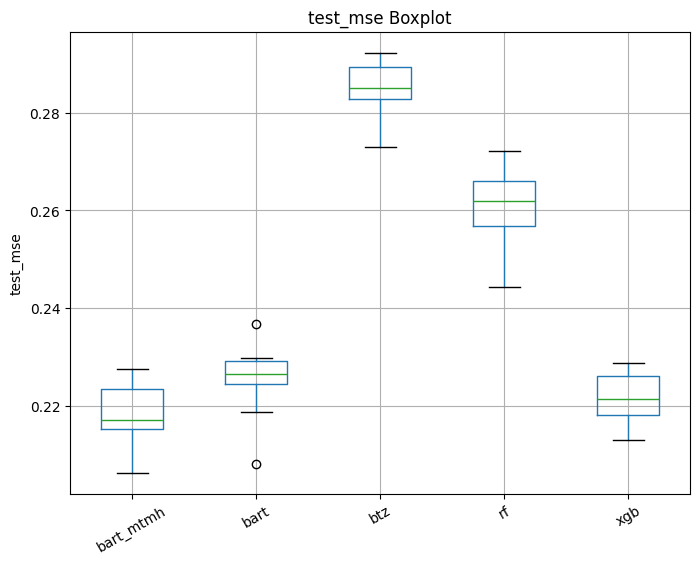

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.139223  0.176117  0.264529  0.036417  0.070528
1      0.137789  0.173865  0.259645  0.036316  0.071458
2      0.134086  0.170469  0.252435  0.035701  0.067329
3      0.142288  0.177370  0.259378  0.036103  0.072052
4      0.138652  0.174837  0.256427  0.034991  0.072937
5      0.134495  0.170738  0.264643  0.036166  0.067958
6      0.138158  0.176353  0.255568  0.035877  0.070881
7      0.132117  0.165932  0.257327  0.036120  0.072070
8      0.139476  0.170888  0.254505  0.035792  0.069747
9      0.135115  0.171589  0.250741  0.035288  0.072473
mean   0.137140  0.172816  0.257520  0.035877  0.070743
std    0.003086  0.003524  0.004640  0.000453  0.001893



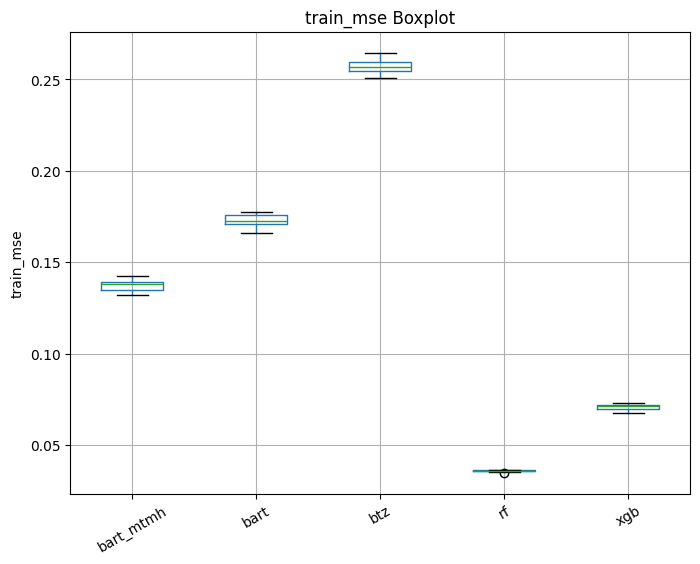

pi_length:
      bart_mtmh      bart       btz
0      1.568501  1.710460  2.170340
1      1.559991  1.691902  2.178068
2      1.540224  1.691306  2.146943
3      1.564423  1.710713  2.167564
4      1.562433  1.689140  2.163001
5      1.535951  1.679489  2.200159
6      1.549329  1.712065  2.165145
7      1.523661  1.667029  2.151457
8      1.562630  1.687140  2.118233
9      1.547935  1.682102  2.148772
mean   1.551508  1.692135  2.160968
std    0.014655  0.014921  0.021714



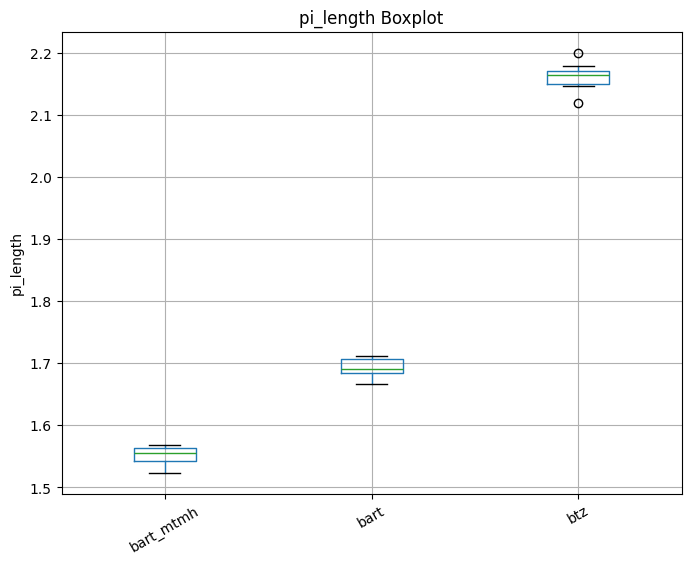

coverage:
      bart_mtmh      bart       btz
0      0.926744  0.931202  0.950194
1      0.926357  0.932946  0.947868
2      0.921899  0.931395  0.945930
3      0.928876  0.939147  0.948837
4      0.928295  0.933915  0.951550
5      0.918217  0.927907  0.947287
6      0.921318  0.937984  0.949612
7      0.911047  0.926744  0.943023
8      0.924225  0.929845  0.945155
9      0.923450  0.930233  0.945736
mean   0.923043  0.932132  0.947519
std    0.005368  0.004006  0.002608



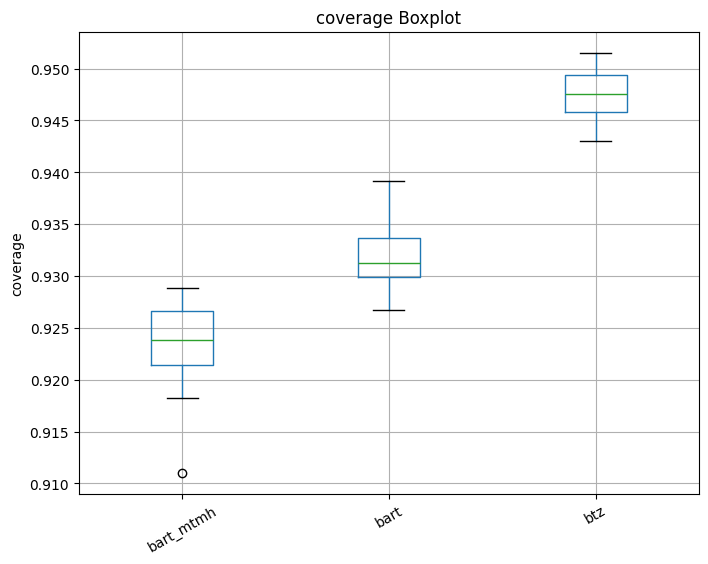

train_time:
       bart_mtmh       bart        btz         rf       xgb
0     514.784626  71.082165  48.547011  16.666785  0.348225
1     521.954198  74.284652  50.025413  11.647877  0.274135
2     523.166976  74.369709  50.703578  10.926449  0.270346
3     521.777609  75.099384  50.550937  11.130068  0.232748
4     517.874256  70.357575  49.384508  14.939918  0.262936
5     522.269598  73.730380  50.729522  12.993128  0.248973
6     518.779766  70.346873  48.509814  16.957305  0.268963
7     518.590917  71.166520  50.174724  13.789909  0.219862
8     522.657672  72.579683  51.344097  11.161685  0.260596
9     521.417267  71.163764  51.373748  11.476988  0.230479
mean  520.327288  72.418071  50.134335  13.169011  0.261726
std     2.694721   1.816301   1.032037   2.322132  0.035741



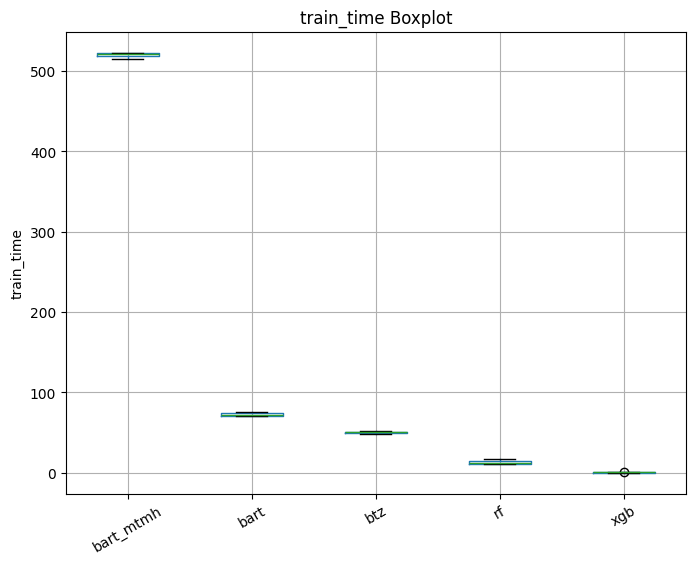

In [12]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [13]:
for k, v in mse_results.items():
    csv_name = f"results/real3_CalHousing_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [14]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real3_CalHousing_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real3_CalHousing_tries.csv", index=False)

In [15]:
df = pd.read_csv("results/real3_CalHousing_tries.csv")
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage   Train_Time
0            1     1.649561   2.022073  0.224104  0.933411   110.895840
1            5     1.517603   1.742035  0.212811  0.930349   308.780929
2           10     1.714388   1.565029  0.217562  0.926279   543.238431
3           50     1.618301   1.516240  0.215560  0.920775  2772.942820
